# CS 135 day17: Decision Tree Classifier Basics

# Objectives

* Learn how to use *probabilistic* decision tree binary classifiers in sklearn
* * Call `fit` to train them on provided labeled dataset
* * Call `predict_proba` to get probabilistic predictions (will give you multiple columns, one per possible label)
* * * use `predict_proba(...)[:,1]` to get just the probabilities of the positive class
* * Call `predict` to get hard binary decisions

* See tradeoffs as a function of different hyperparameters
* * max_depth
* * min_samples_per_leaf
* * We'll reuse the same examples from our experience with Logistic Regression and kNN to provide some common ground

# Outline
* [Part 1: Binary classification with Decision Trees on 1-dim. toy example](#part1)
* [Part 2: Inspecting learned tree structure on toy example](#part2)
* [Part 3: Visualizing decision boundaries of Decision Trees on 2-dim. features](#part3)
* [Part 4 (Bonus): Inspecting learned tree structure on 2-dim. example](#part4)


# Takeaways

* Decision trees produce piecewise constant decision boundaries (as function of features)
* * These boundaries are *axis aligned*, meaning they are always parallel or perpendicular to one of the "elementary" directions in the feature space (along x1 axis, along x2 axis, etc)

In [ ]:
import numpy as np

In [ ]:
import sklearn.tree


In [ ]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

# Setting up a simple classification task with 1-dim features

Let's think about a classification task where:

Each input is just scalar $x$ between -1 and +1.

The "true" label assignment function is as follows:

$$
y(x) = \begin{cases} 
1 & \text{if} ~ x > 0 \\
0 & \text{otherwise}
\end{cases}
$$

The true labeling process also has some noise: after assigning a label with the above function, each example has a ~15% chance of the opposite label. 

This noise makes our classification interesting. The "best case" error rate is about ~15%.

### Make training set for 1-dim. toy example

In [ ]:
# We generated this training set for you.

N = 12

x_tr_N = np.asarray([
    -0.975, -0.825, -0.603, -0.378, -0.284, -0.102,
     0.169,  0.311,  0.431,  0.663,  0.795,  0.976])
x_tr_N1 = x_tr_N.reshape((N,1)) # need an (N,1) shaped array for later use with sklearn

y_tr_N = np.asarray([0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1])

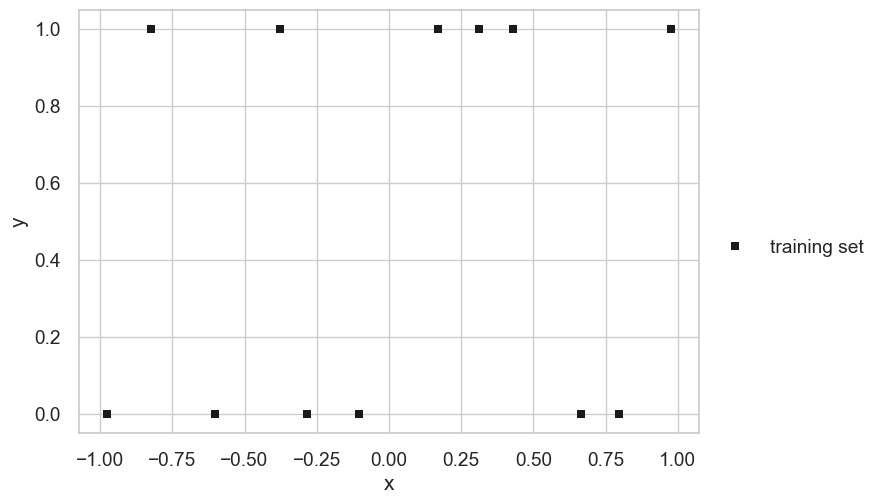

In [ ]:
plt.plot(x_tr_N, y_tr_N, 'ks', label='training set');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(bbox_to_anchor=(1.0, 0.5));

### Make validation set for 1-d toy example

In [ ]:
def make_dataset(n_examples=10, seed=101, flip_fraction=0.15):
    N = int(n_examples)
    prng = np.random.RandomState(seed)

    # Make x values between -1 and 1, roughly evenly spaced
    x_N = np.linspace(-1, 1, N) + 0.05 * prng.randn(N)

    # Make y values such that broadly, the true function says:
    # y_n = 1  if x_n > 0 
    # y_n = 0  otherwise
    y_N = np.asarray(x_N > 0, dtype=np.int32)

    # flip a small percentage of the values
    chosen_ids = prng.permutation(np.arange(N))[:int(np.floor(flip_fraction * N))]
    y_N[chosen_ids] = 1 - y_N[chosen_ids]
    return x_N.reshape((N,1)), y_N

In [ ]:
M = 100
x_va_M1, y_va_M = make_dataset(n_examples=M, seed=201)

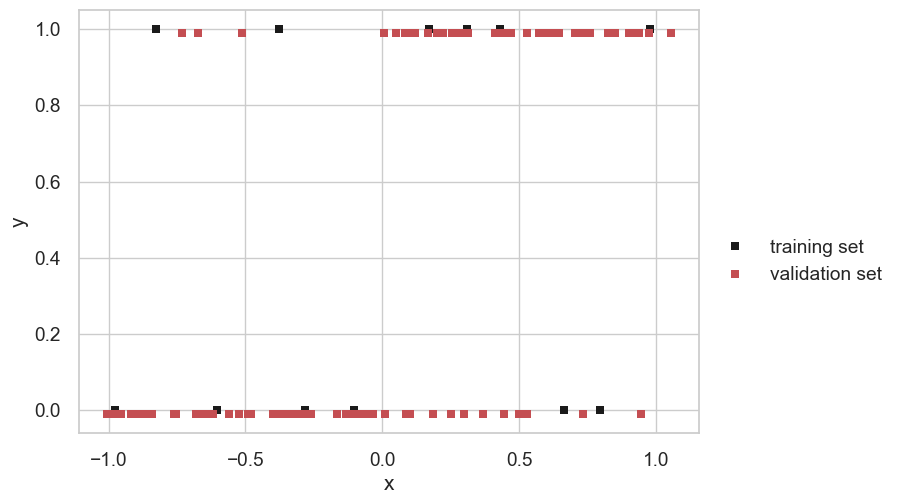

In [ ]:
plt.plot(x_tr_N, y_tr_N, 'ks', label='training set');
plt.plot(x_va_M1, y_va_M - 0.01, 'rs', label='validation set'); # add small vertical offset so you can see both sets

plt.xlabel('x');
plt.ylabel('y');
plt.legend(bbox_to_anchor=(1.0, 0.5));

<a id="part1"></a>

# Part 1: Train a decision tree model for F=1 data

See the docs for DecisionTreeClassifier here: <https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html>

Here, we'll fit a decision tree probabilistic classifier to the above 1-dim. feature dataset.

In [ ]:
# We'll try a few fixed depth values for now... you could select these like any hyperparameter
tree_depth1 = sklearn.tree.DecisionTreeClassifier(max_depth=1)
tree_depth2 = sklearn.tree.DecisionTreeClassifier(max_depth=2)

In [ ]:
tree_depth1.fit(x_tr_N1, y_tr_N)

DecisionTreeClassifier(max_depth=1)

In [ ]:
tree_depth2.fit(x_tr_N1, y_tr_N)

DecisionTreeClassifier(max_depth=2)

### Make predictions using our tree using `predict_proba`

Remember, `predict_proba()` returns the probabilities of ALL possible labels: 0 and 1

There will be two columns, one for each label.

The first column is for the class corresponding to binary label 0.
The second column is for the class corresponding to binary label 1.

In [ ]:
yproba_N2 = tree_depth2.predict_proba(x_tr_N1)
print("yproba_N2")
print("Shape: " + str(yproba_N2.shape))
print(yproba_N2)

yproba_N2
Shape: (12, 2)
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [1.         0.        ]
 [1.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.66666667 0.33333333]
 [0.66666667 0.33333333]
 [0.66666667 0.33333333]]


## Exercise 1a: Obtain a 1D array of the predicted probas for *positive* class only

** Input **: 2D array `yproba_N2` from above, with shape (N, 2)

** Desired output **: We want a 1D array with shape (N,) whos entries contain the probabilities that the training examples are in the positive class.

In [ ]:
yproba1_N = np.zeros(N) # TODO fix me

## Setup : Prepare for a plot over dense grid of inputs

In [ ]:
# Create dense grid of L input examples from -1.5 to 1.5
# so we can better understand the learned predictions
L = 101
dense_x_L1 = np.linspace(-1.5, 1.5, L).reshape((L,1))

In [ ]:
# Apply our trained tree to make predictions along this grid
# Uses the syntax [:,1] to access the column with index 1 (so we only get the probas for positive class)

In [ ]:

yproba1_depth1_dense_L = tree_depth1.predict_proba(dense_x_L1)[:,1]
yproba1_depth2_dense_L = tree_depth2.predict_proba(dense_x_L1)[:,1]


## Plot: predicted probabilities vs. feature value

We can see that the predicted probabilities from Decision Trees are *piecewise constant*.

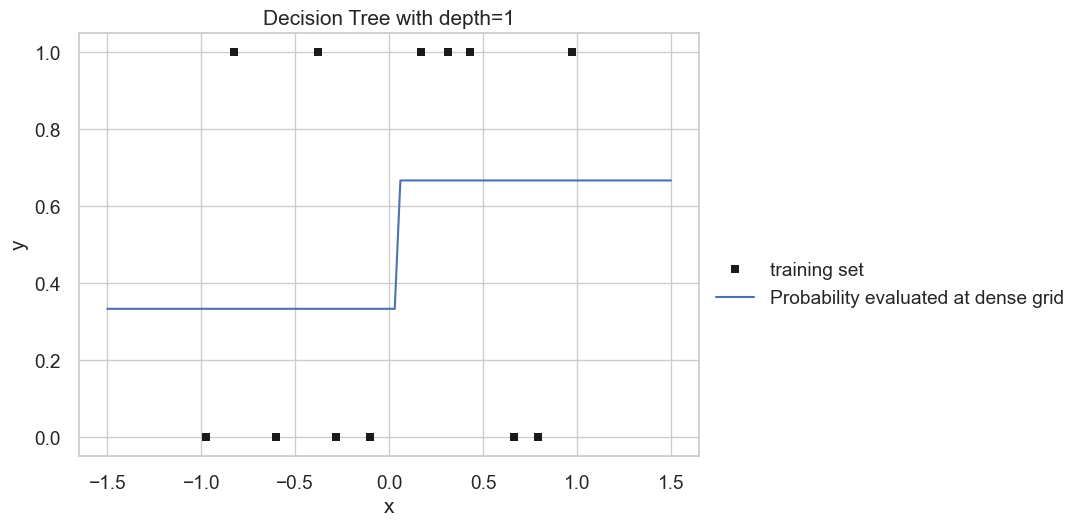

In [ ]:
plt.plot(x_tr_N, y_tr_N, 'ks', label='training set');
plt.plot(dense_x_L1, yproba1_depth1_dense_L, 'b-', label='Probability evaluated at dense grid')

plt.xlabel('x');
plt.ylabel('y');
plt.legend(bbox_to_anchor=(1.0, 0.5));
plt.title("Decision Tree with depth=1");

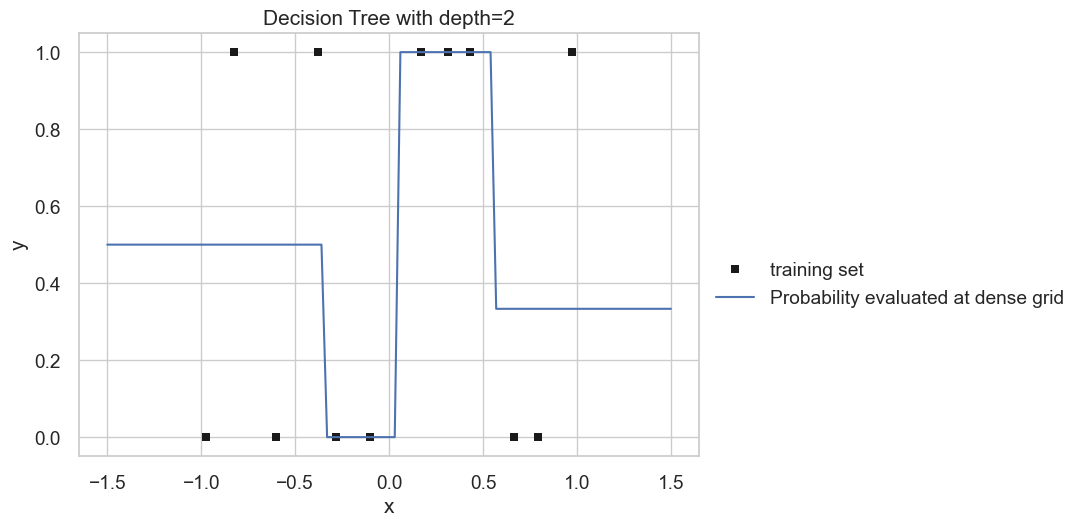

In [ ]:
plt.plot(x_tr_N, y_tr_N, 'ks', label='training set');
plt.plot(dense_x_L1, yproba1_depth2_dense_L, 'b-', label='Probability evaluated at dense grid')

plt.xlabel('x');
plt.ylabel('y');
plt.legend(bbox_to_anchor=(1.0, 0.5));
plt.title("Decision Tree with depth=2");

## Discussion 1b: Why does this plot have piecewise constant probability predictions?

TODO write your answer here.

## Exercise 1c: Try again with a max_depth=6 Decision Tree

In [ ]:
tree_depth6 = None # TODO call sklearn.tree.DecisionTreeClassifier(...) with max_depth hyperparameter set to 6

In [ ]:
# Train the classifier, by calling fit using provided arrays x_tr_N1, y_tr_N
tree_depth6 # TODO fixme

In [ ]:
yproba1_depth6_dense_L = 0.5 * np.ones(L) # TODO call predict_proba on the dense input array, keep only positive class probas

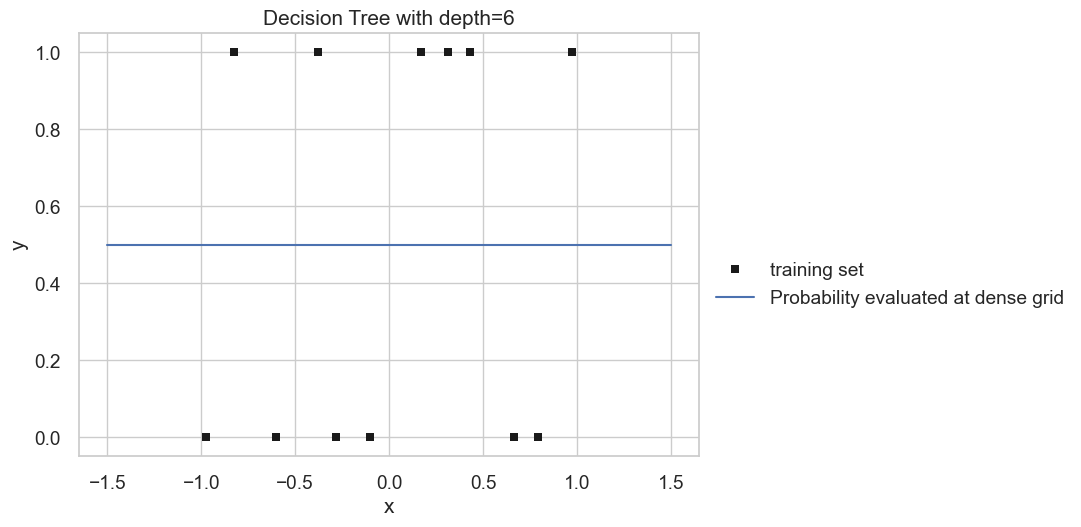

In [ ]:
plt.plot(x_tr_N, y_tr_N, 'ks', label='training set');
plt.plot(dense_x_L1, yproba1_depth6_dense_L, 'b-', label='Probability evaluated at dense grid')

plt.xlabel('x');
plt.ylabel('y');
plt.legend(bbox_to_anchor=(1.0, 0.5));
plt.title("Decision Tree with depth=6");

<a id="part2"></a>

# Part 2: What is stored inside a trained instance of DecisionTreeClassifier 

In [ ]:
from collections import defaultdict

### Setup for Part 2

Use this provided function to make a pretty print-out of the tree's internal structure

No TODO items here... feel free to scroll down...

In [ ]:
def pretty_print_sklearn_tree(tree_clf, feature_names=['x']):
    ''' Print out a nice summary of the provided tree.

    Args
    ----
    tree_clf : instance of sklearn.tree.DecisionTreeClassifier
    feature_names : list of strings
        Provides a printable 'name' for each feature the model was trained with.

    Returns
    -------
    Nothing. Results printed to stdout.
    
    Notes
    -----
    Based on an sklearn tutorial. Here's a brief summary of how it works:

    # After training, any DecisionTreeClassifier an attribute called tree_ 
    # which stores the tree structure and allows access to key attributes.
    # The binary tree tree_ is represented as a number of parallel arrays.
    # The i-th element of each array holds information about the node `i`.
    # Node 0 is the tree's root.
    # Notes:
    # - Some of the arrays only apply to either leaves or split nodes, resp.
    # - In this case the values of nodes of the other type are arbitrary!
    #
    # Among those arrays, we have:
    #   - left_child, id of the left child of the node
    #   - right_child, id of the right child of the node
    #   - feature, feature used for splitting the node
    #   - threshold, threshold value at the node
    #   - value, counts of each class for train examples reaching this node

    By manipulating these arrays, we can parse the tree structure.
    '''

    n_nodes = tree_clf.tree_.node_count
    children_left = tree_clf.tree_.children_left
    children_right = tree_clf.tree_.children_right
    feature = tree_clf.tree_.feature
    threshold = tree_clf.tree_.threshold

    # The tree structure can be traversed to compute various properties
    # such as:
    # * the depth of each node 
    # * whether or not it is a leaf.

    node_depth_N = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaf_N = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth_N[node_id] = parent_depth + 1

        if (children_left[node_id] != children_right[node_id]):
            # Internal decision node
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            # Leaf node
            is_leaf_N[node_id] = True

    print("The binary tree structure has %s nodes." % n_nodes)
    depths_U, counts_U = np.unique(node_depth_N, return_counts=True)
    for uu in range(depths_U.size):
        is_at_cur_depth_N = depths_U[uu] == node_depth_N
        is_leaf_at_cur_depth_N = np.logical_and(
            is_leaf_N,
            is_at_cur_depth_N,
            )
        print("- depth %3d has %4d nodes, of which %4d are leaves" % (
            depths_U[uu], counts_U[uu], np.sum(is_leaf_at_cur_depth_N)))

    print("The decision tree:  (Note: Y = 'yes' to above question; N = 'no')")
    n_seen_by_depth = defaultdict(int)

    for i in range(n_nodes):
        cur_depth = node_depth_N[i]
        count_at_cur_depth = n_seen_by_depth[cur_depth]

        # Every other printout at same depth should alternate Y and N labels
        if node_depth_N[i] == 0:
            decision_str = '' # base case
        elif count_at_cur_depth % 2 == 0:
            decision_str = 'Y '
        else:
            decision_str = 'N '

        if is_leaf_N[i]:
            if isinstance(tree_clf, sklearn.tree.DecisionTreeClassifier):
                n_samples_here = tree_clf.tree_.n_node_samples[i]
                proba1 = tree_clf.tree_.value[i,0,1]
                print("%s%sLeaf: p(y=1 | this leaf) = %.3f (%d total training examples)" % (
                    node_depth_N[i] * "  ", decision_str, proba1, n_samples_here))
            else:
                print("%s%sLeaf: yhat at this leaf = %.3f" % (
                    node_depth_N[i] * "  ", decision_str, tree_clf.tree_.value[i].sum()))                        

        else:
            print("%s%sDecision: X['%s'] <= %.2f?" % (
                node_depth_N[i] * "  ",
                decision_str,
                feature_names[feature[i]],
                threshold[i],
                ))

        # Increment our counter so we get the alternating Y/N labels right
        n_seen_by_depth[cur_depth] += 1

    print()



## Display tree with depth 1

In [ ]:
pretty_print_sklearn_tree(tree_depth1, feature_names=['x'])

The binary tree structure has 3 nodes.
- depth   0 has    1 nodes, of which    0 are leaves
- depth   1 has    2 nodes, of which    2 are leaves
The decision tree:  (Note: Y = 'yes' to above question; N = 'no')
Decision: X['x'] <= 0.03?
  Y Leaf: p(y=1 | this leaf) = 0.333 (6 total training examples)
  N Leaf: p(y=1 | this leaf) = 0.667 (6 total training examples)



## Discussion 2a: Does this structure above align with the depth=1 visualization in Part 1?

* Does the number of training examples assigned to each leaf make sense?
* Does the probability predicted by each leaf make sense?


## Display tree with depth 2

In [ ]:
pretty_print_sklearn_tree(tree_depth2)

The binary tree structure has 7 nodes.
- depth   0 has    1 nodes, of which    0 are leaves
- depth   1 has    2 nodes, of which    0 are leaves
- depth   2 has    4 nodes, of which    4 are leaves
The decision tree:  (Note: Y = 'yes' to above question; N = 'no')
Decision: X['x'] <= 0.03?
  Y Decision: X['x'] <= -0.33?
    Y Leaf: p(y=1 | this leaf) = 0.500 (4 total training examples)
    N Leaf: p(y=1 | this leaf) = 0.000 (2 total training examples)
  N Decision: X['x'] <= 0.55?
    Y Leaf: p(y=1 | this leaf) = 1.000 (3 total training examples)
    N Leaf: p(y=1 | this leaf) = 0.333 (3 total training examples)



## Discussion 2b: Does this structure above align with the depth=2 visualization in Part 1?


TODO discuss

## Display tree with depth 6

In [ ]:
# TODO fixme, call pretty_print_sklearn_tree on tree_depth6

# Setup for Part 3

### Define simple dataset of points in 2D space

Don't worry about the details of this setup.
Just try to understand the plots below.

In [ ]:
def create_2d_dataset(N=100, noise_stddev=0.1, random_state=0):
    random_state = np.random.RandomState(int(random_state))

    mA_2 = np.asarray([1, 0])
    covA_22 = np.square(noise_stddev) * np.eye(2)
    
    mB_2 = np.asarray([0, 0])
    covB_22 = np.square(noise_stddev) * np.eye(2)

    mC_2 = np.asarray([0, 1])
    covC_22 = np.square(noise_stddev) * np.eye(2)

    # Draw data from 3 "Gaussian" blobs
    xA_N2 = random_state.multivariate_normal(mA_2, covA_22, size=N)
    xB_N2 = random_state.multivariate_normal(mB_2, covB_22, size=N)
    xC_N2 = random_state.multivariate_normal(mC_2, covC_22, size=N)

    x_N2 = np.vstack([xA_N2, xB_N2, xC_N2])
    y_N = np.hstack([np.ones(xA_N2.shape[0]), np.zeros(xB_N2.shape[0]), np.ones(xC_N2.shape[0])])
    
    return x_N2, y_N

## Create the dataset with 100 points per class

In [ ]:
x_N2, y_N = create_2d_dataset(N=100, noise_stddev=0.3)

## Define function to plot data as scatterpoints in 2d

In [ ]:
def plot_pretty_data_colored_by_labels(x_N2, y_N):
    plt.plot(x_N2[y_N==0,0], x_N2[y_N==0,1], color='r', marker='x', linestyle='', markersize=5, mew=2, label='y=0');
    plt.plot(x_N2[y_N==1,0], x_N2[y_N==1,1], color='b', marker='+', linestyle='', markersize=8, mew=2, label='y=1');

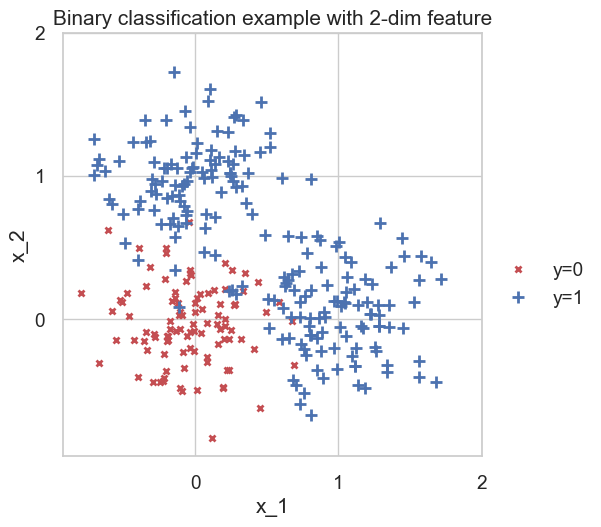

In [ ]:
plot_pretty_data_colored_by_labels(x_N2, y_N);
plt.legend(bbox_to_anchor=(1.0, 0.5));
plt.xlabel('x_1');
plt.ylabel('x_2');
plt.gca().set_aspect(1.0);
plt.xticks([0, 1, 2]);
plt.yticks([0, 1, 2]);
plt.title("Binary classification example with 2-dim feature");

### Define function to make pretty plots of predicted probability color fields

You don't need to understand this in detail. Just a utility function.

In [ ]:
def plot_pretty_probabilities_for_clf(
        clf,
        do_show_colorbar=False,
        x1_ticks=np.asarray([0, 2, 4]),
        x2_ticks=np.asarray([0, 2, 4]),
        c_levels=np.linspace(0, 1, 100),
        c_ticks=np.asarray([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        x1_grid=np.linspace(-1, 2.3, 100),
        x2_grid=np.linspace(-1, 2.3, 100)):
    cur_ax = plt.gca()
    
    G = x1_grid.size
    H = x2_grid.size
    
    # Get regular grid of G x H points, where each point is an (x1, x2) location
    x1_GH, x2_GH = np.meshgrid(x1_grid, x2_grid)
    
    # Combine the x1 and x2 values into one array
    # Flattened into M = G x H rows
    # Each row of x_M2 is a 2D vector [x_m1, x_m2]
    x_M2 = np.hstack([x1_GH.flatten()[:,np.newaxis], x2_GH.flatten()[:,np.newaxis]])
    
    # Predict proba for each point in the flattened grid
    yproba1_M = clf.predict_proba(x_M2)[:,1]
    
    # Reshape the M probas into the GxH 2D field
    yproba1_GH = np.reshape(yproba1_M, x1_GH.shape)
    
    cmap = plt.cm.RdYlBu
    my_contourf_h = plt.contourf(x1_GH, x2_GH, yproba1_GH, levels=c_levels, vmin=0, vmax=1.0, cmap=cmap)
    
    plt.xticks(x1_ticks, x1_ticks);
    plt.yticks(x2_ticks, x2_ticks);
    
    if do_show_colorbar:
        left, bottom, width, height = plt.gca().get_position().bounds
        cax = plt.gcf().add_axes([left+1.1*width, bottom, 0.03, height])
        plt.colorbar(my_contourf_h, orientation='vertical', cax=cax, ticks=c_ticks);
        plt.sca(cur_ax);

### Define function to visualize hard decisions made as threshold

You don't need to understand this in detail. Just a utility function.

In [ ]:
def plot_pretty_decision_boundaries_for_clf(
        clf,
        threshold=0.5,
        do_show_colorbar=False,
        x1_ticks=np.asarray([0, 2, 4]),
        x2_ticks=np.asarray([0, 2, 4]),
        c_levels=np.linspace(0, 1, 100),
        c_ticks=np.asarray([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        x1_grid=np.linspace(-1, 2.3, 100),
        x2_grid=np.linspace(-1, 2.3, 100)):
    cur_ax = plt.gca()
    
    G = x1_grid.size
    H = x2_grid.size
    
    # Get regular grid of G x H points, where each point is an (x1, x2) location
    x1_GH, x2_GH = np.meshgrid(x1_grid, x2_grid)
    
    # Combine the x1 and x2 values into one array
    # Flattened into M = G x H rows
    # Each row of x_M2 is a 2D vector [x_m1, x_m2]
    x_M2 = np.hstack([x1_GH.flatten()[:,np.newaxis], x2_GH.flatten()[:,np.newaxis]])
    
    # Predict proba for each point in the flattened grid
    yproba1_M = clf.predict_proba(x_M2)[:,1]
    yhat_M = yproba1_M >= threshold
    
    # Reshape the M probas into the GxH 2D field
    yhat_GH = np.reshape(yhat_M, x1_GH.shape)
    
    cmap = plt.cm.RdYlBu
    my_contourf_h = plt.contourf(x1_GH, x2_GH, yhat_GH, levels=c_levels, vmin=0, vmax=1.0, cmap=cmap)
    
    plt.xticks(x1_ticks, x1_ticks);
    plt.yticks(x2_ticks, x2_ticks);
    
    if do_show_colorbar:
        left, bottom, width, height = plt.gca().get_position().bounds
        cax = plt.gcf().add_axes([left+1.1*width, bottom, 0.03, height])
        plt.colorbar(my_contourf_h, orientation='vertical', cax=cax, ticks=c_ticks);
        plt.sca(cur_ax);

<a id="part3"></a>

# Part 3: Visualization of DecisionTree predictions as we vary max_depth

Generally, max depth is one of the key hyperparameters that controls model complexity.

### Figure: DecisionTree predicted proba (colors) over 2D plane of x1, x2 

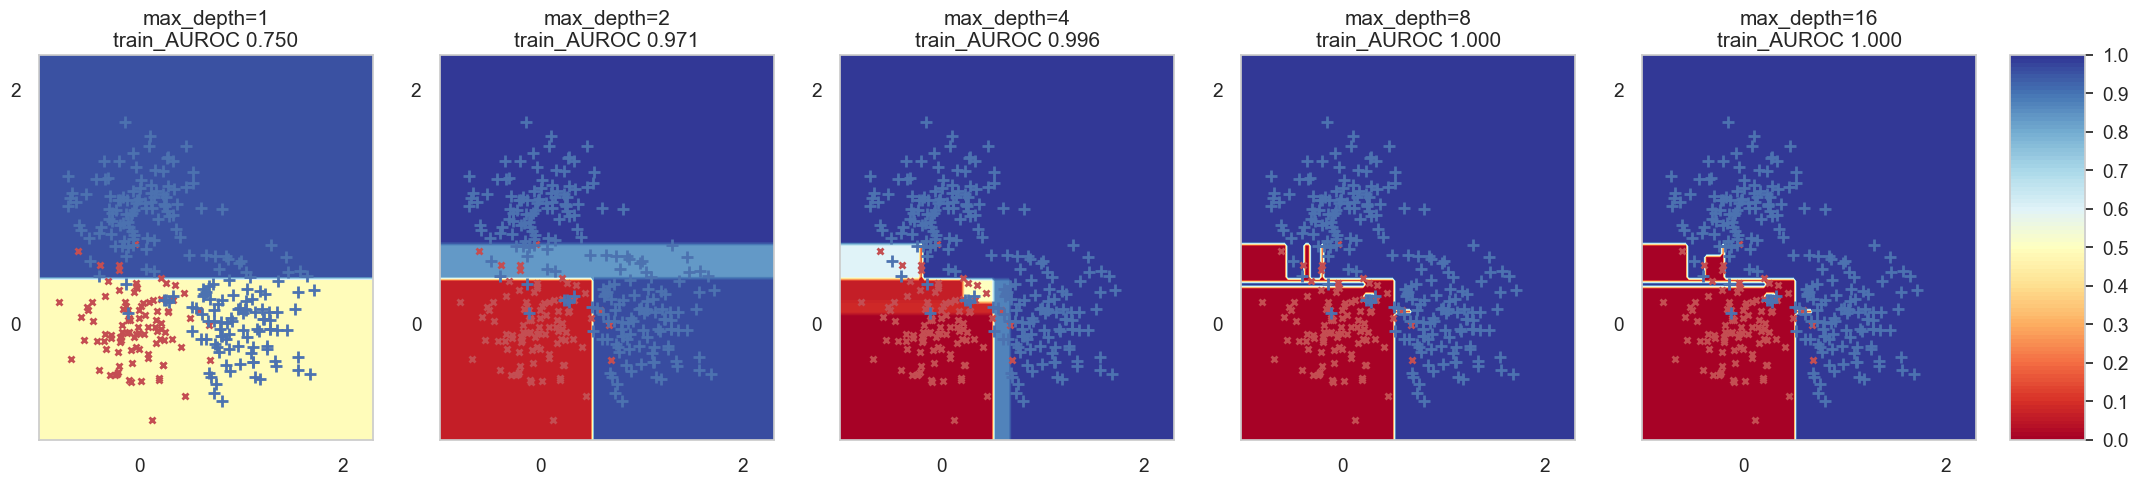

In [ ]:
max_depth_grid = [1, 2, 4, 8, 16]

trees_by_depth = dict()

ncols = len(max_depth_grid)
fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, max_depth in enumerate(max_depth_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    clf = sklearn.tree.DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(x_N2, y_N)
    auroc = sklearn.metrics.roc_auc_score(y_N, clf.predict_proba(x_N2)[:,1])

    plot_pretty_probabilities_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_N2, y_N);
    
    plt.title("max_depth=%d\ntrain_AUROC %.3f" % (max_depth, auroc))
    
    # Store for later
    trees_by_depth[max_depth] = clf

## KNN: hard binary decisions (colors) over 2D plane of (x1, x2)

Using Threshold: 0.5

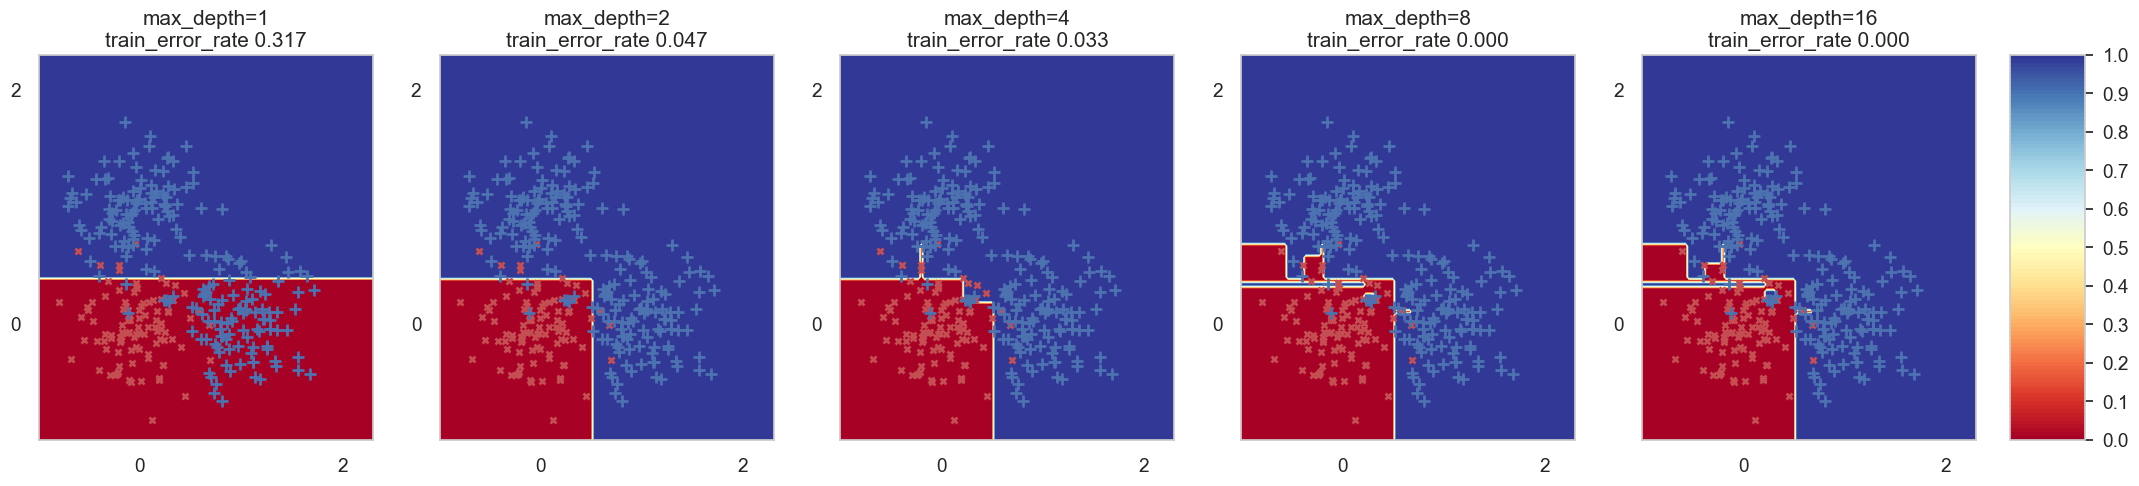

In [ ]:
max_depth_grid = [1, 2, 4, 8, 16]
ncols = len(max_depth_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, max_depth in enumerate(max_depth_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    clf = sklearn.tree.DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(x_N2, y_N)
    err_rate = np.mean(np.logical_xor(y_N, clf.predict(x_N2)))
    
    plot_pretty_decision_boundaries_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_N2, y_N);
    plt.title("max_depth=%d\ntrain_error_rate %.3f" % (max_depth, err_rate))


<a id="part6"></a>

### Discussion 3a: At what depth does the classifier get zero training error on the training set? Would we expect this on the validation set?

### Discussion 3b: How could you select the maximum depth hyperparameter on a new dataset?

* What search strategies would you consider?

* What minimum and maximum candidate values would you consider?

<a id="part4"></a>

# Part 4 (Bonus) Inspect the learned tree structure on the F=2 problem above

Remember, above we stored the learned trees inside our trees_by_depth dict.

We'll now inspect each one to get a sense of how these models vary from simple to complex.

## DEPTH 1

In [ ]:
pretty_print_sklearn_tree(trees_by_depth[1], feature_names=['x1', 'x2'])

The binary tree structure has 3 nodes.
- depth   0 has    1 nodes, of which    0 are leaves
- depth   1 has    2 nodes, of which    2 are leaves
The decision tree:  (Note: Y = 'yes' to above question; N = 'no')
Decision: X['x2'] <= 0.39?
  Y Leaf: p(y=1 | this leaf) = 0.486 (185 total training examples)
  N Leaf: p(y=1 | this leaf) = 0.957 (115 total training examples)



## DEPTH 2

In [ ]:
pretty_print_sklearn_tree(trees_by_depth[2], feature_names=['x1', 'x2'])

The binary tree structure has 7 nodes.
- depth   0 has    1 nodes, of which    0 are leaves
- depth   1 has    2 nodes, of which    0 are leaves
- depth   2 has    4 nodes, of which    4 are leaves
The decision tree:  (Note: Y = 'yes' to above question; N = 'no')
Decision: X['x2'] <= 0.39?
  Y Decision: X['x1'] <= 0.50?
    Y Leaf: p(y=1 | this leaf) = 0.061 (98 total training examples)
    N Leaf: p(y=1 | this leaf) = 0.966 (87 total training examples)
  N Decision: X['x2'] <= 0.69?
    Y Leaf: p(y=1 | this leaf) = 0.833 (30 total training examples)
    N Leaf: p(y=1 | this leaf) = 1.000 (85 total training examples)



## DEPTH 4

In [ ]:
pretty_print_sklearn_tree(trees_by_depth[4], feature_names=['x1', 'x2'])

The binary tree structure has 23 nodes.
- depth   0 has    1 nodes, of which    0 are leaves
- depth   1 has    2 nodes, of which    0 are leaves
- depth   2 has    4 nodes, of which    1 are leaves
- depth   3 has    6 nodes, of which    1 are leaves
- depth   4 has   10 nodes, of which   10 are leaves
The decision tree:  (Note: Y = 'yes' to above question; N = 'no')
Decision: X['x2'] <= 0.39?
  Y Decision: X['x1'] <= 0.50?
    Y Decision: X['x2'] <= 0.18?
      Y Decision: X['x2'] <= 0.08?
        Y Leaf: p(y=1 | this leaf) = 0.000 (63 total training examples)
        N Leaf: p(y=1 | this leaf) = 0.083 (12 total training examples)
      N Decision: X['x1'] <= 0.22?
        Y Leaf: p(y=1 | this leaf) = 0.067 (15 total training examples)
        N Leaf: p(y=1 | this leaf) = 0.500 (8 total training examples)
    N Decision: X['x1'] <= 0.70?
      Y Decision: X['x1'] <= 0.69?
        Y Leaf: p(y=1 | this leaf) = 0.875 (16 total training examples)
        N Leaf: p(y=1 | this leaf) = 0.00